# Morphological tessellation

One of the main features of `momepy` is the ability to generate and analyse morphological tessellation (MT). One can imagine MT like Voronoi tessellation generated around building polygons instead of points. The similarity is not accidental - the core of MT is a Voronoi diagram generated by `shapely.voronoi_polygons`. We'll explain key parts of tessellation and explore its application in the real world.

## Using exemplary data

In [1]:
import geopandas as gpd
import momepy

In [2]:
buildings = gpd.read_file(
    momepy.datasets.get_path("bubenec"), layer="buildings"
)

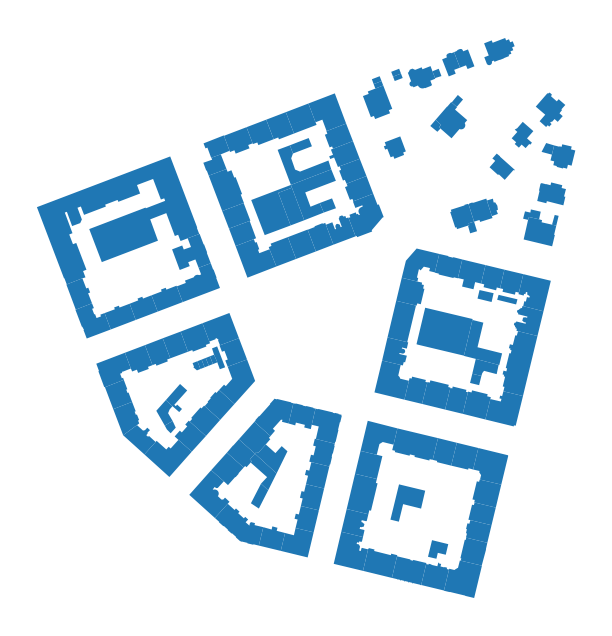

In [3]:
ax = buildings.plot(figsize=(8, 8))
ax.set_axis_off()


As Voronoi tessellation tends to go to infinity for edge points, we have to define a limit for tessellation. It can be the area of your case study represented as a Polygon or MultiPolygon or you can use `momepy.buffered_limit` to generate such limit as a set maximal distance from buildings.

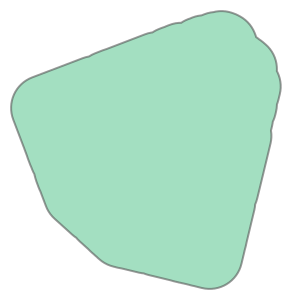

In [4]:
limit = momepy.buffered_limit(buildings, buffer=100)
limit

Other crucial attributes of tessellation algorithm are `segment` and `shrink`. Both are predefined as balanced values between the computational demands and a quality of a result. Segment defines the maximal distance between points generated to represent building footprint, shrink defines how much should be building buffered (inwards) to generate a gap between adjacent polygons. If you want to reduce memory requirements, you can use larger `segment` distance, but it may cause imprecision. 

In [5]:
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

In [6]:
tessellation.head()

0    POLYGON ((1603577.153 6464348.291, 1603576.946...
1    POLYGON ((1603166.356 6464326.62, 1603166.425 ...
2    POLYGON ((1603006.941 6464167.63, 1603009.97 6...
3    POLYGON ((1602944.839 6464116.337, 1602954.616...
4    POLYGON ((1603084.231 6464104.386, 1603083.773...
dtype: geometry

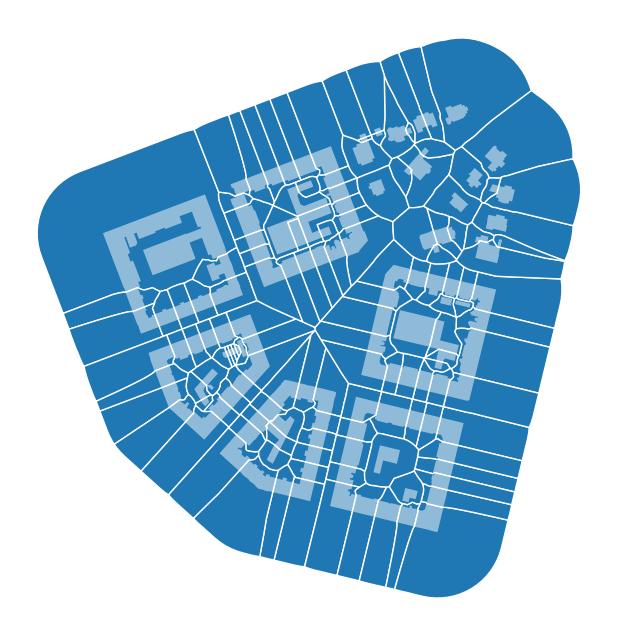

In [7]:
ax = tessellation.plot(edgecolor="white", figsize=(8, 8))
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()

Generated tessellation can be linked to buildings using index, which is directly inherited from buildings.

## Generating tessellation based on OpenStreetmap

To illustrate a more real-life example, let's try to generate tessellation based on a small town retrieved from OSM. We will use `osmnx` package to get the data.

In [8]:
import osmnx as ox

gdf = ox.features.features_from_place(
    "Kahla, Germany", tags={"building": True}
)
gdf_projected = ox.projection.project_gdf(gdf)

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


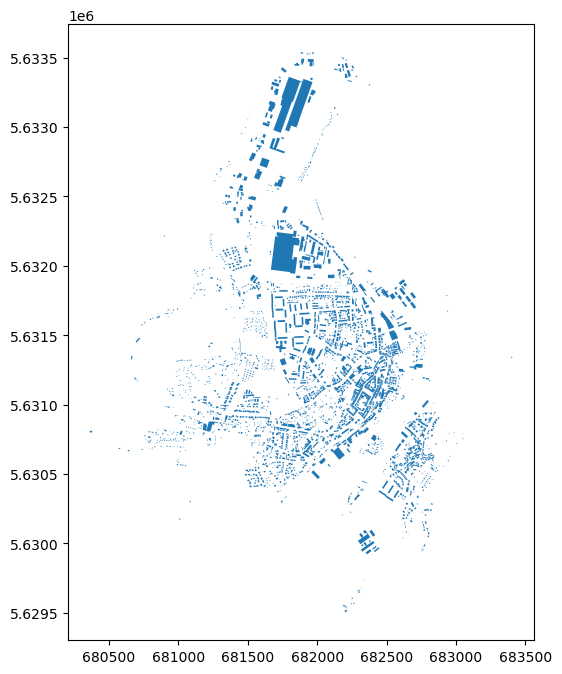

In [9]:
ax = gdf_projected.plot(figsize=(8, 8))
ax.set_axis_off()

While working with real-life data, we often face issues with their quality. To avoid some of the possible errors, we should preprocess (clean) the data. It is often done semi-manually within the GIS environment. `momepy` offers (experimental) `momepy.preprocess` to handle some of the expected issues. 

In [10]:
buildings = momepy.preprocess(
    gdf_projected.reset_index(), size=30, compactness=0.2, islands=True
)

Loop 1 out of 2.


Identifying changes:   0%|          | 0/3014 [00:00<?, ?it/s]

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Changing geometry:   0%|          | 0/37 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/2567 [00:00<?, ?it/s]

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

What has happened? 

1. All auxiliary buildings (smaller than 30 square meters defined in `size`) were dropped.
2. Possible adjacent structures of specific circular compactness values (long and narrow) were joined to their parental buildings.
3. All buildings fully within other buildings (share 100% of the exterior boundary) were joined to their parental buildings.

Tessellation requires the limit. We will generate it using the same buffer method as above but this time using the adaptive buffer distance to partially mitigate edge effects.

In [11]:
limit = momepy.buffered_limit(buildings, buffer="adaptive", max_buffer=50)

At this moment, we have everything we need to generate morphological tessellation. It might take a while for larger `GeoDataFrames`.

In [12]:
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

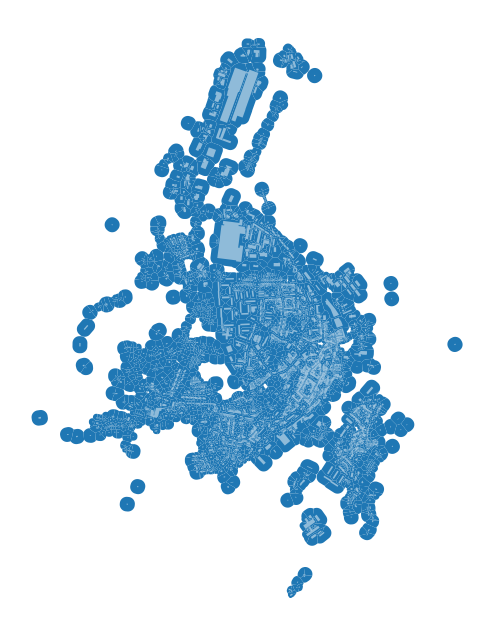

In [18]:
ax = tessellation.plot(figsize=(8, 8))
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()

Zooming closer to check the result:

(5631000.0, 5632000.0)

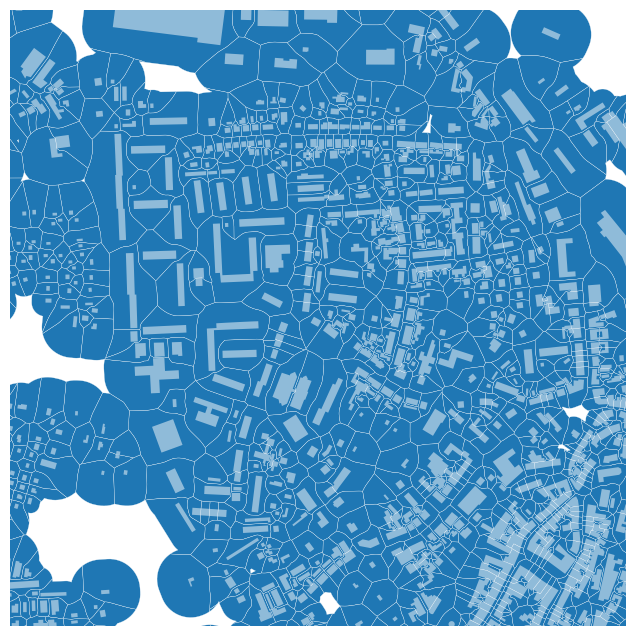

In [17]:
ax = tessellation.plot(edgecolor="white", linewidth=0.2, figsize=(8, 8))
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
ax.set_xlim(681500, 682500)
ax.set_ylim(5631000, 5632000)

And we are done. Morphological tessellation is generated and ready for any further analysis.

### Troubleshooting

In some cases, the result may not be optimal. You can use `momepy.verify_tessellation` function to check the result. In 99% of cases, issues are due to errors in input data. Two types of issue are possible:

1. Collaped buildings

In this case, some of the building shapes collapsed during the shrinkage. It should not happen as shrink distance is usually quite small, but you might be able to resolve it by setting smaller `shrink` distance. However, we would recommend fixing the data manually.

2. MultiPolygons

This is a more common issue, which is again caused by imprecise data. Often caused by long and extremely narrow shapes or overlap of buildings. While some of the analysis might work even with MultiPolygon geometry, it does not really make sense, so we would recommend fixing the data beforehand.

However, for most of the data of higher quality, you should not see any of these warnings.

In [15]:
collapsed, multipolygons = momepy.verify_tessellation(tessellation, buildings)

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_16437/3617767949.py:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [392, 397, 692, 877, 1040, 1087, 1268, 1495, 1688, 2124, 2431, 2473, 2556].
  collapsed, multipolygons = momepy.verify_tessellation(tessellation, buildings)


In [16]:
print(f"Collapsed: {collapsed}\n\nMultiPolygons: {multipolygons}")

Collapsed: Index([], dtype='object')

MultiPolygons: Index([392, 397, 692, 877, 1040, 1087, 1268, 1495, 1688, 2124, 2431, 2473,
       2556],
      dtype='int64')
